In [ ]:
!nvidia-smi

Thu May 20 06:21:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%pip install -q tensorflow-addons[tensorflow]
%pip install -q simpleitk
# %pip install -q colab_ssh
%pip install -q wandb

     |████████████████████████████████| 686kB 8.2MB/s 
     |████████████████████████████████| 47.4MB 64kB/s 
     |████████████████████████████████| 1.8MB 8.3MB/s 
     |████████████████████████████████| 133kB 53.5MB/s 
     |████████████████████████████████| 174kB 49.2MB/s 
     |████████████████████████████████| 102kB 13.3MB/s 
     |████████████████████████████████| 71kB 10.3MB/s 


In [ ]:
!gdown https://drive.google.com/uc?id=1jYb-dKqywLm5bQ5esP6YSV5xuBzqBPqm

Downloading...
From: https://drive.google.com/uc?id=1jYb-dKqywLm5bQ5esP6YSV5xuBzqBPqm
To: /content/BRATS_Dataset.tar.gz
2.76GB [00:24, 113MB/s]


In [ ]:
!apt -qq install pigz

The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  pigz
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 57.4 kB of archives.
After this operation, 259 kB of additional disk space will be used.
Selecting previously unselected package pigz.
(Reading database ... 160715 files and directories currently installed.)
Preparing to unpack .../archives/pigz_2.4-1_amd64.deb ...
Unpacking pigz (2.4-1) ...
Setting up pigz (2.4-1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [ ]:
!pigz -dc BRATS_Dataset.tar.gz | tar xf -

In [ ]:
!rm BRATS_Dataset.tar.gz

In [ ]:
%cd /content
!rm -rf 3D_res_attn_Unet

/content


In [ ]:
!git clone https://github.com/ShivamShrirao/3D_res_attn_Unet

Cloning into '3D_res_attn_Unet'...
remote: Enumerating objects: 117, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 117 (delta 75), reused 77 (delta 35), pack-reused 0
Receiving objects: 100% (117/117), 473.38 KiB | 1.92 MiB/s, done.
Resolving deltas: 100% (75/75), done.


In [ ]:
%cd 3D_res_attn_Unet

/content/3D_res_attn_Unet


In [ ]:
%load_ext tensorboard
%load_ext autoreload
%autoreload 2

In [ ]:
import SimpleITK as sitk

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
import glob
from tqdm.notebook import tqdm
from time import time
%matplotlib inline

In [ ]:
from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale


In [ ]:
def get_data_paths(dataset_path):
    t1 = glob.glob(dataset_path+'/*GG/*/*t1.nii.gz')
    t2 = glob.glob(dataset_path+'/*GG/*/*t2.nii.gz')
    t1ce = glob.glob(dataset_path+'/*GG/*/*t1ce.nii.gz')
    flair = glob.glob(dataset_path+'/*GG/*/*flair.nii.gz')
    seg = glob.glob(dataset_path+'/*GG/*/*seg.nii.gz')
    return list(zip(t1, t2, t1ce, flair, seg))

In [ ]:
train_paths = get_data_paths('../BRATS_Dataset/brats_dataset/')
val_paths = get_data_paths('../BRATS_Dataset/brats_test_dataset/')

In [ ]:
len(train_paths), len(val_paths)

(285, 50)

In [ ]:
from model.preprocess import *

In [ ]:
mean = tf.constant([0.06301811, 0.05202341, 0.04396216, 0.05345017], shape=(1, 4, 1, 1, 1))
std  = tf.constant([0.14905235, 0.12771605, 0.1042005 , 0.12938198], shape=(1, 4, 1, 1, 1))

In [ ]:
# mean = []
# std = []
# for tp in tqdm(train_paths[0:100]):
#     img, lbl = load_img(tp)
#     img = tf.cast(img, tf.float32)/255.0
#     mean.append(tf.reduce_mean(img, axis=[1,2,3]))
#     std.append(tf.math.reduce_std(img, axis=[1,2,3]))
# mean = tf.reshape(tf.reduce_mean(mean, axis=0), (1, 4, 1, 1, 1))
# std = tf.reshape(tf.reduce_mean(std, axis=0), (1, 4, 1, 1, 1))

In [ ]:
depth = 128 # 155
height = 192 # 240
width = 160 # 240
(155-depth, 240-height, 240-width)

(27, 48, 80)

In [ ]:
def random_crop3D(imgs, lbls, train=True):          # Crops image to size (128, 192, 160)
    d_cr, h_cr, w_cr = 13, 24, 40
    if train:
        if tf.random.uniform([], 0, 1, dtype=tf.float32) <= 0.8:
            d_cr = tf.random.uniform([], 0, 27, dtype=tf.int32)
            h_cr = tf.random.uniform([], 0, 48, dtype=tf.int32)
            w_cr = tf.random.uniform([], 0, 80, dtype=tf.int32)
    imgs = imgs[:, :, d_cr:d_cr+depth, h_cr:h_cr+height, w_cr:w_cr+width]
    lbls = lbls[:, :, d_cr:d_cr+depth, h_cr:h_cr+height, w_cr:w_cr+width]
    return imgs, lbls

In [ ]:
def final_augmentation(img, lbl, train=True):       # input img[B, 4, 155, 240, 240], output[B, 4, 128, 192, 160]
    img, lbl = random_crop3D(img, lbl, train)
    img = tf.cast(img, tf.float32)/255.0
    lbl = tf.cast(lbl, tf.float32)
    if train:
        img = tf.image.random_brightness(img, 0.2)      # source code checked, it's fine for 3D
    # img = tf.image.per_image_standardization(img)   # source code checked, it's fine for 3D
    img = (img - mean) / std
    return img, lbl

In [ ]:
BATCH_SIZE = 2
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
def get_tfds(data_paths, train=False):
    # 53.3373920917511 s
    dataset = tf.data.Dataset.from_tensor_slices(data_paths)
    if train:
        dataset = dataset.shuffle(len(data_paths))
    dataset = dataset.map(load_paths_wrapper, num_parallel_calls=AUTOTUNE)
    if train:
        dataset = dataset.map(random_rotate3D, num_parallel_calls=AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    if train:
        dataset = dataset.map(random_flip3D, num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(lambda x,y: final_augmentation(x,y,train), num_parallel_calls=AUTOTUNE)      # remove for test,val
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [ ]:
train_ds = get_tfds(train_paths, train=True)
val_ds = get_tfds(val_paths)

In [ ]:
import wandb
from wandb.keras import WandbCallback

In [ ]:
wandb.login()

wandb: Currently logged in as: shivamshrirao (use `wandb login --relogin` to force relogin)


True

In [ ]:
config_defaults = {
    'activation'            : 'leaky_relu',
    'batch_size'            : BATCH_SIZE,
    'block_type'            : 'AttnBottleneckBlock',
    'clr_step_size'         : 10,
    'clr_offset_ep'         : 5,
    'groups'                : 48,
    'dp_rate'               : 0.25,
    'dropout_type'          : 'Spatial',
    'frac_dv'               : 0,
    'loss_function'         : 'FocalTversky',
    'max_lr'                : 8e-4,
    'min_lr'                : 2e-6,
    'nheads'                : 8,
    'norm'                  : 'gn',
    'optimizer'             : 'adamw',
    'vary_weight_decay'     : True,
    'weight_decay'          : 2e-5,     # max weight decay
}
CONFIG = config_defaults

In [ ]:
run = wandb.init(project="3D_res_attn_Unet", entity="shivamshrirao", config=config_defaults)
CONFIG = wandb.config

In [ ]:
mean.numpy().ravel(), std.numpy().ravel()

(array([0.06301811, 0.05202341, 0.04396216, 0.05345017], dtype=float32),
 array([0.14905235, 0.12771605, 0.1042005 , 0.12938198], dtype=float32))

In [ ]:
tf.keras.backend.set_image_data_format('channels_first')

In [ ]:
## attention shortcuts to be used.
## try attention on the unet shortcuts
## try Global Context Block
## try input image pyramid and deep supervised output layers (output from intermediate layers (fuse with conv-sigmoid like U^2net ??))
## TRY PIXELSHUFFLE
## Try SPARSE CONV NET https://github.com/facebookresearch/SparseConvNet

In [ ]:
from model.conv_blocks import ConvNorm, NormAct, BasicBlock, AttnBottleneckBlock, down_stack, up_stack

In [ ]:
def enc_dec(x, block, frac_dv, stack_args):     # x(64,64,96,80)
    x1 = down_stack(x ,  64, nblocks=2, block=block, strides=2, **stack_args)     # (256,32,48,40)
    x2 = down_stack(x1, 128, nblocks=2, block=block, strides=2, **stack_args)     # (512,16,24,20)
    x3 = down_stack(x2, 256, nblocks=2, block=block, strides=2, frac_dv=frac_dv, **stack_args) # (1024, 8,12,10)
    x4 = down_stack(x3, 256, nblocks=3, block=block, strides=2, frac_dv=frac_dv, **stack_args) # (1024, 4, 6, 5)

    y = up_stack(x4,x3, 128, nblocks=3, block=block, strides=2, frac_dv=frac_dv, **stack_args) # (1024+1024->512,8,12,10)
    y = up_stack(y, x2,  64, nblocks=2, block=block, strides=2, **stack_args)     # (512+512->256,16,24,20)
    y = up_stack(y, x1,  32, nblocks=2, block=block, strides=2, **stack_args)     # (256+256->128,32,48,40)
    y = up_stack(y, x ,  16, nblocks=1, block=block, strides=2, **stack_args)     # (128+ 64-> 64,64,96,80)
    return y


def build_network(cfg, block, input_shape=(4,128,192,160), classes=4):
    stack_args = {'activation': cfg['activation'], 'groups': cfg['groups'], 'norm': cfg['norm'],
                  'dp_rate': cfg['dp_rate'], 'dropout_type': cfg['dropout_type']}

    inp = layers.Input(shape=input_shape)                           # ( 4,128,192,160)
    x = inp
    x = ConvNorm(32, kernel_size=3, strides=2, activation=cfg['activation'], norm=cfg['norm'])(x)   # (32,64,96,80)
    x = ConvNorm(64, kernel_size=3, do_norm_act=False)(x)                               # (64, 64, 96, 80)

    x = enc_dec(x, block, cfg['frac_dv'], stack_args)                                   # (64, 64, 96, 80)

    x = NormAct(activation=cfg['activation'], norm=cfg['norm'])(x)
    x = layers.UpSampling3D(data_format="channels_first")(x)                            # (64,128,192,160)
    x = ConvNorm(16, kernel_size=3, activation=cfg['activation'], norm=cfg['norm'])(x)  # (16,128,192,160)
    x = ConvNorm(classes, kernel_size=3, do_norm_act=False)(x)                          #(3,128,192,160)
    x = layers.Softmax(axis=1)(x)         # softmax cause each pixel has unique class, no overlap with other classes, verified.

    return tf.keras.Model(inputs=inp, outputs=x)

In [ ]:
block = AttnBottleneckBlock
CONFIG['block_type'] = block.__name__
model = build_network(CONFIG, block, input_shape=(4,depth,height,width), classes=4)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 4, 128, 192, 0                                            
__________________________________________________________________________________________________
conv_norm_4 (ConvNorm)          (None, 32, 64, 96, 8 3520        input_19[0][0]                   
__________________________________________________________________________________________________
conv_norm_5 (ConvNorm)          (None, 64, 64, 96, 8 55360       conv_norm_4[0][0]                
__________________________________________________________________________________________________
attn_bottleneck_block_17 (AttnB (None, 256, 32, 48,  43344       conv_norm_5[0][0]                
____________________________________________________________________________________________

In [ ]:
wandb.log({"model": wandb.Image("/content/model.png")})

In [ ]:
from tensorflow.python.client import session
from tensorflow.python.summary import summary

In [ ]:
log_dir = "/content/trace_log"
!rm -rf $log_dir

@tf.function
def trace(x):
    return model(x)

data = tf.random.normal((2,) + model.input_shape[1:])
data = tf.constant(data)

imported_g = trace.get_concrete_function(data).graph

# Export the graph
with session.Session(graph=imported_g) as sess:
    pb_visual_writer = summary.FileWriter(log_dir)
    pb_visual_writer.add_graph(sess.graph)

In [ ]:
%tensorboard --logdir /content/trace_log

In [ ]:
from google.colab.output import eval_js
print(eval_js("google.colab.kernel.proxyPort(6006)"))

https://2wi4nm079zg-496ff2e9c6d22116-6006-colab.googleusercontent.com/


In [41]:
import gc
gc.collect()

8701

In [ ]:
# model = tf.keras.models.load_model(wandb.restore("model-best.h5").name, custom_objects={'ConvNorm': ConvNorm,
#                                                                                         'NormAct': NormAct,
#                                                                                         'AttnBottleneckBlock': AttnBottleneckBlock,
#                                                                                         'BasicBlock': BasicBlock,
#                                                                                         'SqueezeExcite': SqueezeExcite,
#                                                                                         'MHSA3D': MHSA3D,
#                                                                                         'AbsPosEmb': AbsPosEmb,
#                                                                                         })

In [ ]:
from model.losses import *
from model.utils import *

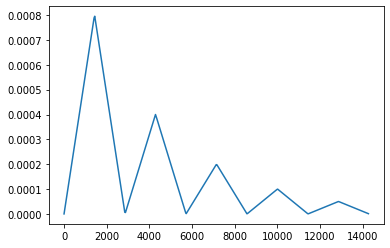

In [ ]:
steps_per_epoch = int(np.ceil(len(train_paths)/BATCH_SIZE))
clr = tfa.optimizers.Triangular2CyclicalLearningRate(
            initial_learning_rate=CONFIG["min_lr"],
            maximal_learning_rate=CONFIG["max_lr"],
            step_size=CONFIG["clr_step_size"] * steps_per_epoch,
            scale_mode="cycle")
domain = range(0, 100*steps_per_epoch, 32)
lr_log = [clr(i).numpy() for i in domain]
plt.plot(domain, lr_log)
plt.show()

In [ ]:
def get_wdc(op):
    lr = op.learning_rate
    wdc = CONFIG["weight_decay"]*lr/CONFIG["max_lr"]
    return wdc

initial_epoch = 0
clr_offset_ep = CONFIG["clr_offset_ep"]

def get_lr(op):
    lr = clr(op.iterations + (initial_epoch + clr_offset_ep)*steps_per_epoch)
    if tf.executing_eagerly():
        return lr.numpy()
    else:
        return lr

In [ ]:
if CONFIG["optimizer"] == 'adamw':
    opt = tfa.optimizers.AdamW(learning_rate=lambda: clr, weight_decay=lambda : CONFIG["weight_decay"])
    # wd_schedule = tf.optimizers.schedules.ExponentialDecay(5e-5, 100, 0.9)    # weight_decay=lambda : None
    opt.learning_rate = lambda : get_lr(opt)
    if CONFIG["vary_weight_decay"]:
        opt.weight_decay = lambda : get_wdc(opt)
elif CONFIG["optimizer"] == 'adam':            # or just make weight_decay=0
    opt = tf.keras.optimizers.Adam(learning_rate=clr)
opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)

In [ ]:
if CONFIG["loss_function"] == 'FocalTversky':
    loss_function = FocalTversky()
elif CONFIG["loss_function"] == 'cce':
    loss_function = cce

In [ ]:
model.compile(optimizer=opt, loss=loss_function, metrics=[dsc])

In [ ]:
wandb_cb = WandbCallback(monitor='dsc', mode='max')

In [ ]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        img, lbl = next(iter(val_ds))
        pred = self.model(img)
        i = epoch % 2
        img = img[i,1].numpy()
        mn = img.min()
        mx = img.max()
        img = (img - mn)/(mx - mn) * 255
        lbl = lbl[i,1:].numpy()*255
        pred = pred[i,1:].numpy()*255
        get_gif(img, lbl, pred, "out.gif")
        wandb.log({"Outputs": wandb.Image("out.gif")})

In [ ]:
history = model.fit(train_ds,
                    epochs=100,
                    steps_per_epoch=np.ceil(len(train_paths)/BATCH_SIZE),
                    validation_data=val_ds,
                    validation_steps=np.ceil(len(val_paths)//BATCH_SIZE),
                    initial_epoch=initial_epoch,
                    workers=4,
                    use_multiprocessing=True,
                    callbacks=[CustomCallback(), wandb_cb])

Epoch 1/100
143/143 [==============================] - 477s 3s/step - loss: 3.4472 - dsc: 0.0272 - val_loss: 3.2685 - val_dsc: 0.0255


wandb: ERROR Can't save model, h5py returned error: get_config() missing 1 required positional argument: 'self'


Epoch 2/100
143/143 [==============================] - 435s 3s/step - loss: 2.9785 - dsc: 0.1356 - val_loss: 2.7085 - val_dsc: 0.2307
Epoch 3/100
143/143 [==============================] - 435s 3s/step - loss: 2.3156 - dsc: 0.3618 - val_loss: 2.8234 - val_dsc: 0.1910
Epoch 4/100
143/143 [==============================] - 432s 3s/step - loss: 2.3159 - dsc: 0.3560 - val_loss: 2.5787 - val_dsc: 0.2651
Epoch 5/100
143/143 [==============================] - 430s 3s/step - loss: 2.1926 - dsc: 0.3872 - val_loss: 2.6896 - val_dsc: 0.2178
Epoch 6/100
143/143 [==============================] - 429s 3s/step - loss: 2.1704 - dsc: 0.3846 - val_loss: 2.0071 - val_dsc: 0.4116
Epoch 7/100
143/143 [==============================] - 433s 3s/step - loss: 1.8809 - dsc: 0.4474 - val_loss: 3.1391 - val_dsc: 0.0777
Epoch 8/100
143/143 [==============================] - 427s 3s/step - loss: 1.8132 - dsc: 0.4727 - val_loss: 2.5415 - val_dsc: 0.2359
Epoch 9/100
143/143 [==============================] - 432s 3s

In [ ]:
model.evaluate(val_ds, steps=np.ceil(len(val_paths)//BATCH_SIZE))

25/25 [==============================] - 34s 1s/step - loss: 0.7378 - dsc: 0.8147


[0.7378356456756592, 0.8146770596504211]

In [ ]:
scores = []
for i, (a,b) in tqdm(enumerate(train_ds)):
    if i==steps_per_epoch:
        break
    o = model(a)
    o = tf.cast(o, tf.float32)
    scores.append(dsc(b,o))

In [ ]:
np.mean(scores, axis=0)

array([0.4047957 , 0.4720509 , 0.42634007], dtype=float32)

In [ ]:
run.finish()

_runtime,43535
_timestamp,1621469371
_step,200
epoch,99
loss,0.96436
dsc,0.75595
val_loss,0.73784
val_dsc,0.81468
best_dsc,0.75603
best_epoch,94


_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
dsc,▁▄▄▅▆▆▇▇▇▇▇▇▇▇▇████▇▇███████████████████
val_loss,█▇▅▆▄▃▂▂▂▂▂▂▃▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_dsc,▁▂▄▃▅▆▇▇█▇▇▇▆█████▇▇▇███████████████████
